Подключаем все необходимые библиотеки (и заодно что-то лишнее, вдруг пригодится):

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn. model_selection import train_test_split
from sklearn. model_selection import RepeatedStratifiedKFold
from sklearn. model_selection import cross_val_score
from sklearn. discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
sns.set_theme(style="ticks")

Запишем данные в dataframe, переменную "качество" будем рассматривать как классифиццирующую 
(на 2 класса- качество вина ниже 6 или выше) и выведем первые 5 строк:

In [2]:
df = pd.read_csv('winequality-red2.csv', delimiter=',')
df = df.assign(quality = df['quality'] >= 6)
print(df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4    False  
1      9.8    False  
2      9.8    False 

Удалим из рассмотрения free.sulfur.dioxide, так как есть total.sulfur.dioxide и удалим citric.acid, так как есть fixed.acidity.
Представим наши данные на парном графике:

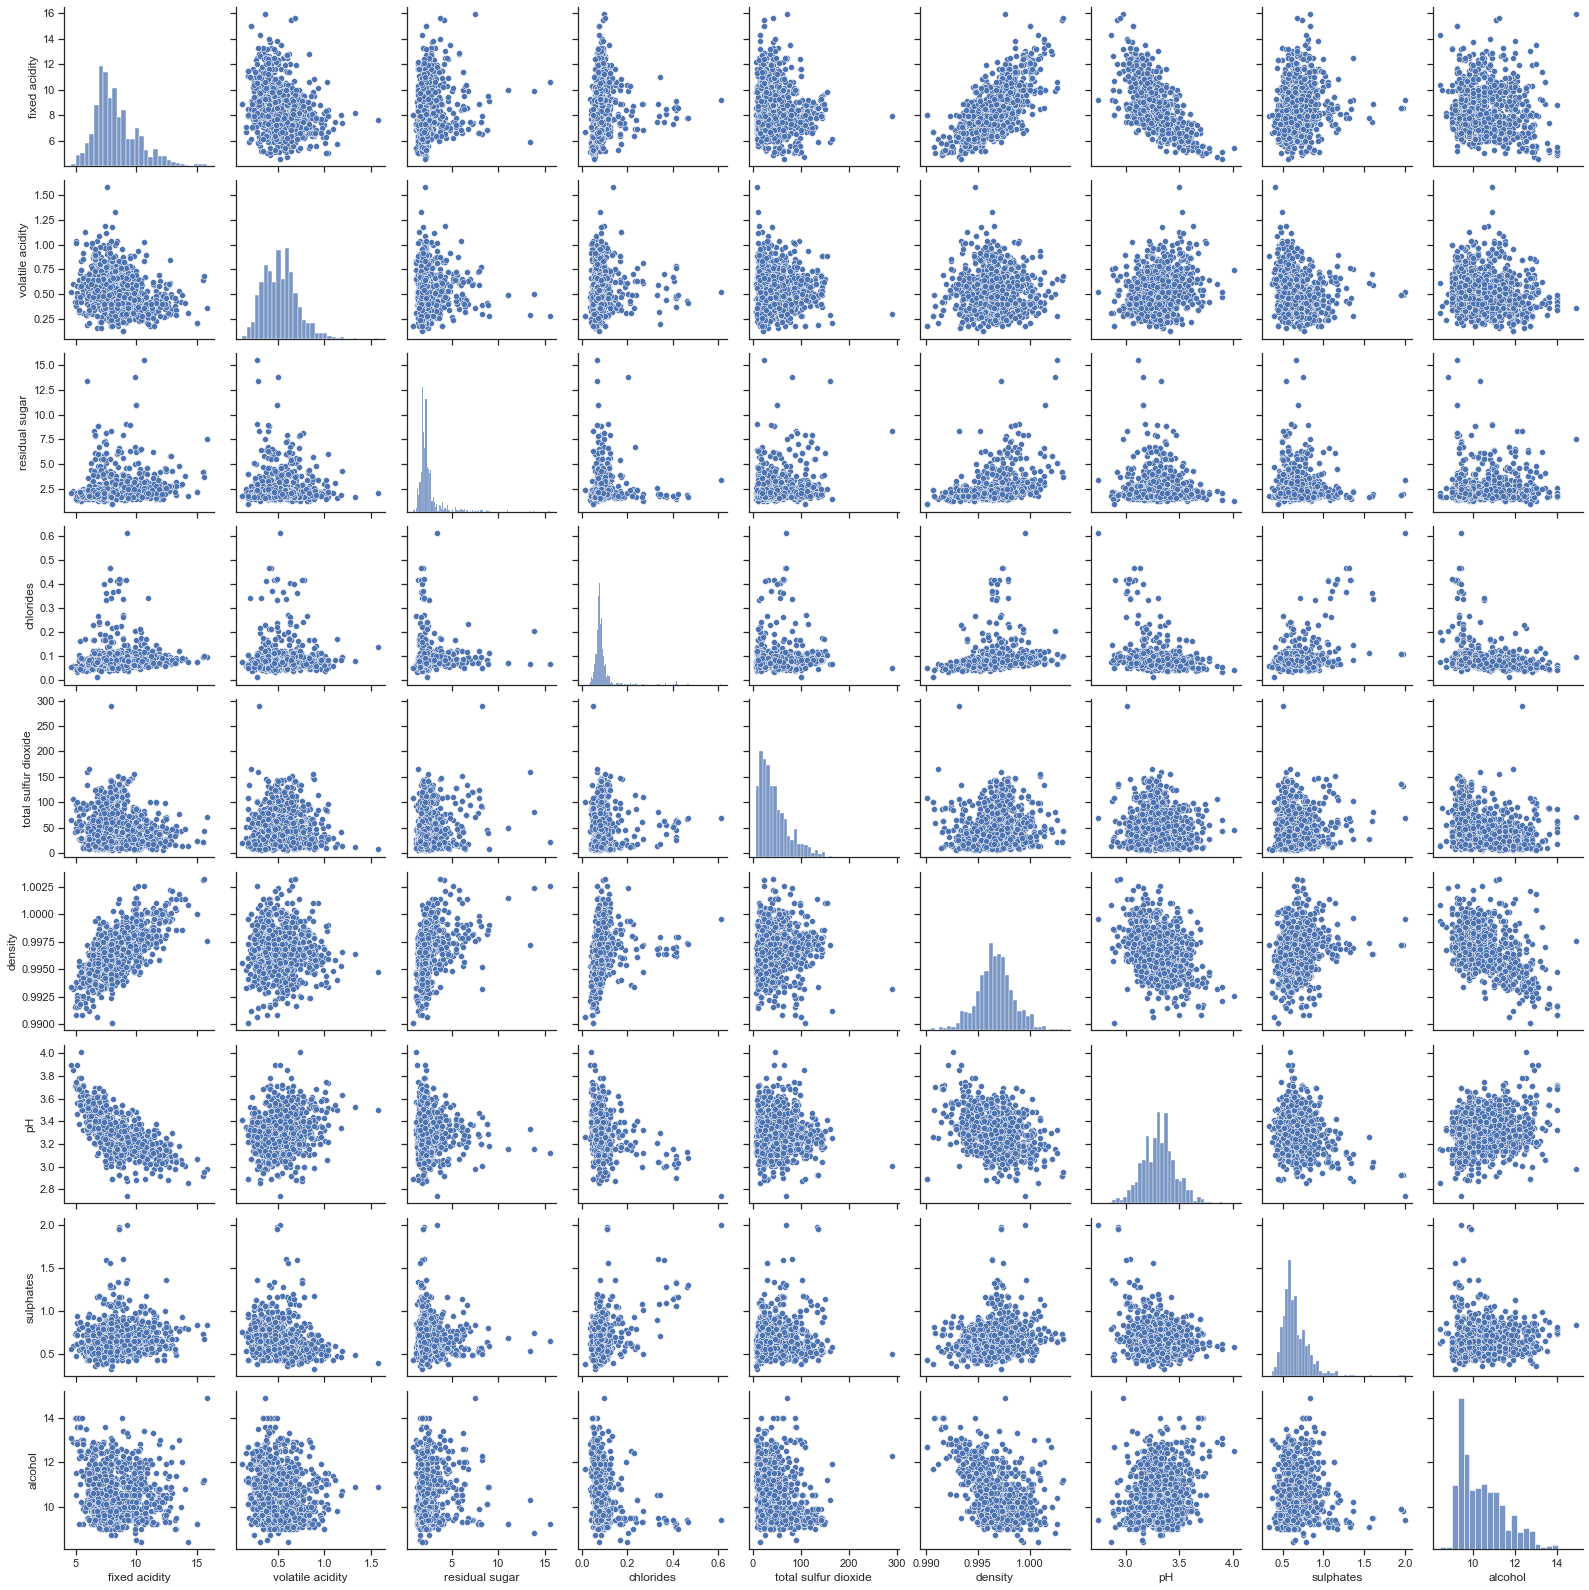

In [3]:
df1 = df[['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']]
df1_train, df1_test = train_test_split(df1, test_size=0.2)
plt.show(sns.pairplot(df1_train.iloc[:, :-1]))

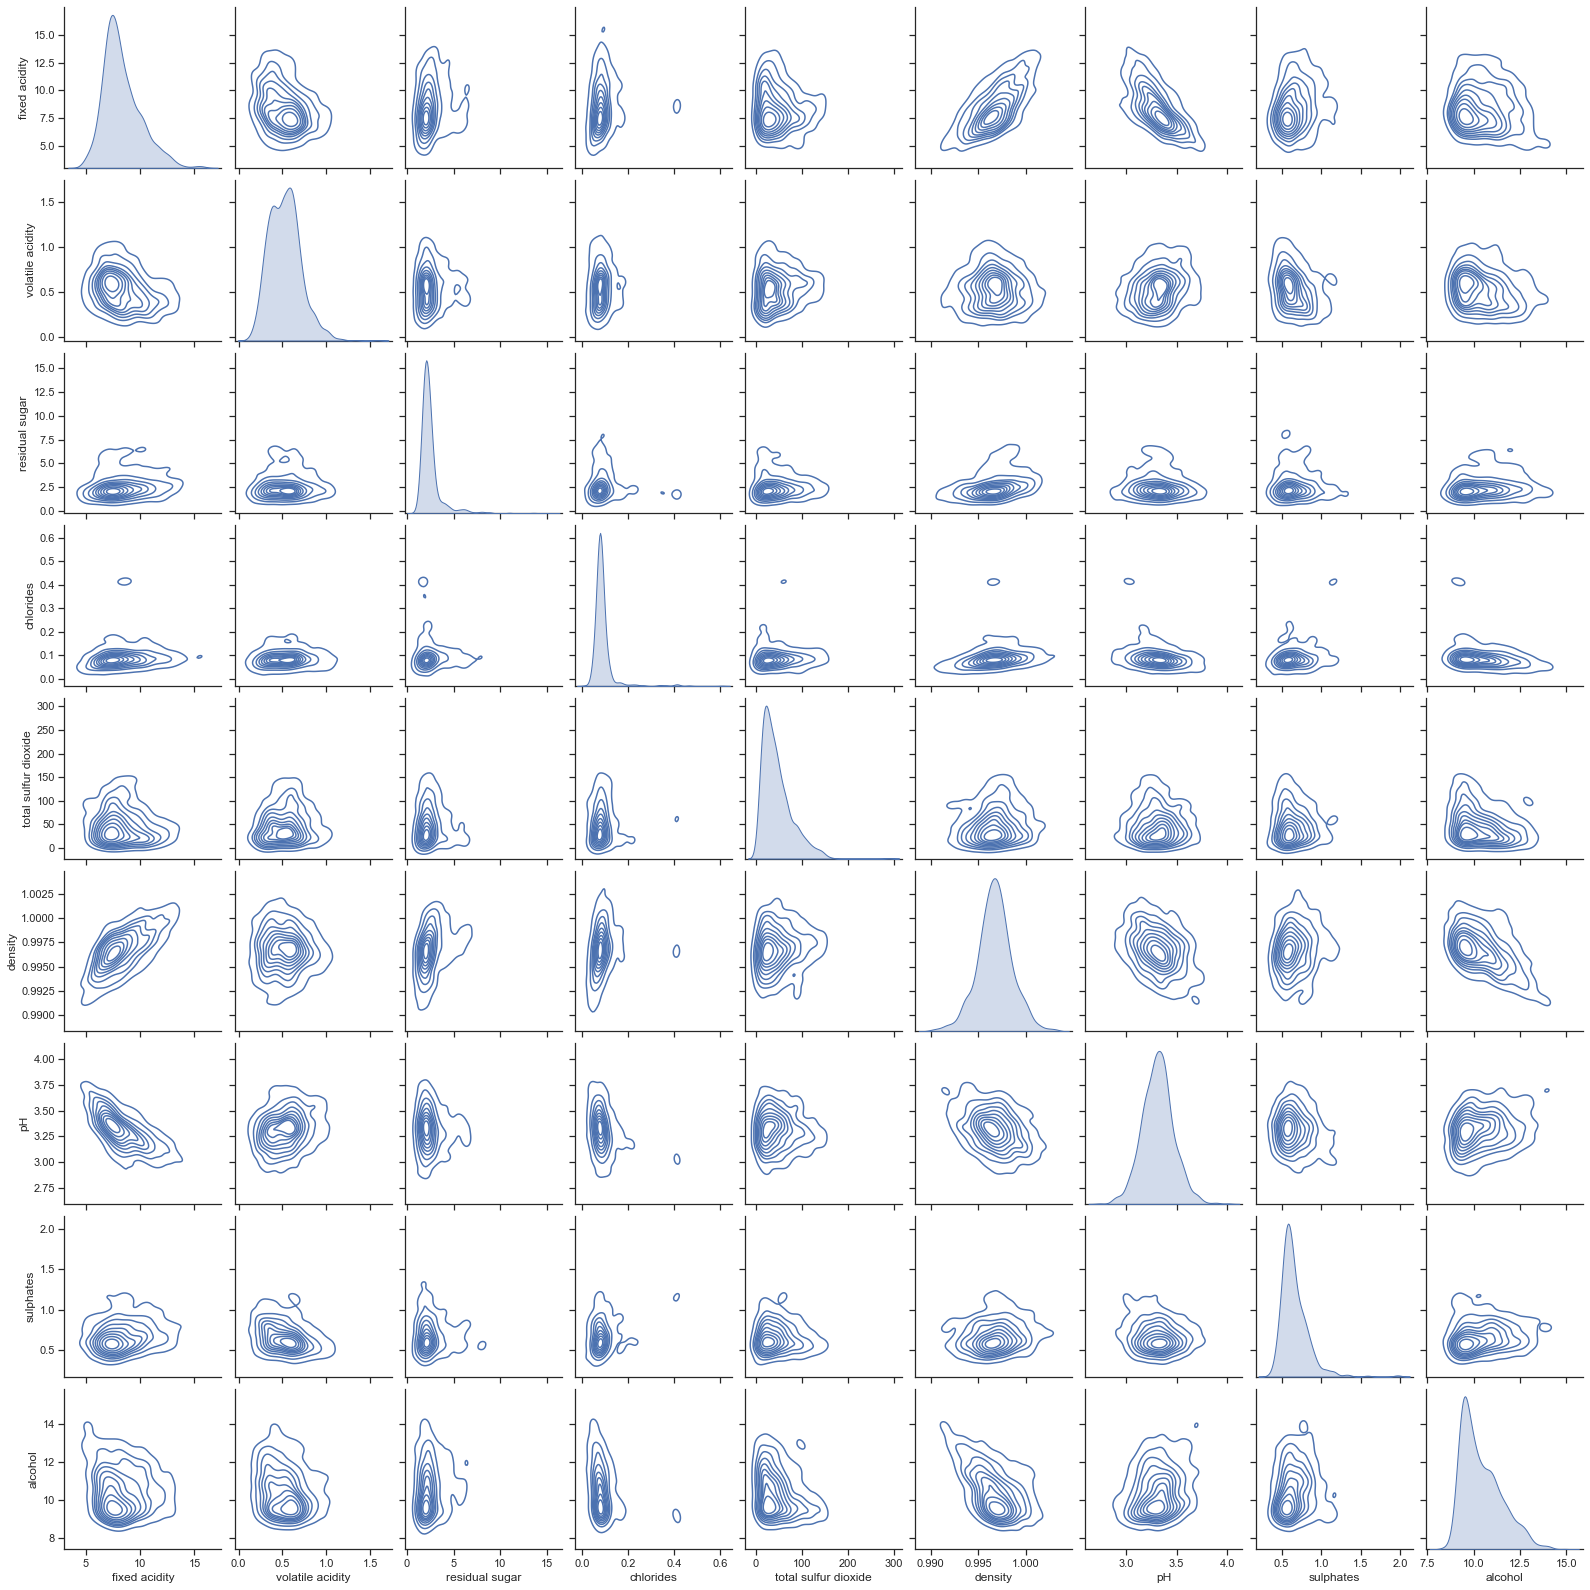

In [4]:
plt.show(sns.pairplot(df1_train.iloc[:, :-1], kind="kde"))

Прологарифмируем 1, 3, 4, 5, 8, 9. И снова изобразим данные, теперь уже с расскраской по нашей классифицирующей переменной:

In [5]:
df1_train.insert(1, 'fixed_acidity_log', np.log(df1_train['fixed acidity']))
df1_train.insert(1, 'residual_sugar_log', np.log(df1_train['residual sugar']))
df1_train.insert(1, 'volatile_acidity', df1_train['volatile acidity'])
df1_train.insert(1, 'chlorides_log', np.log(df1_train['chlorides']))
df1_train.insert(1, 'total_sulfur_dioxide_log', np.log(df1_train['total sulfur dioxide']))
df1_train.insert(1, 'pH_log', np.log(df1_train['pH']))
df1_train.insert(1, 'sulphates_log', np.log(df1_train['sulphates']))
df1_train.insert(1, 'alcohol_log', np.log(df1_train['alcohol']))

In [6]:
df1_train = df1_train.drop(['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol'], axis = 1)

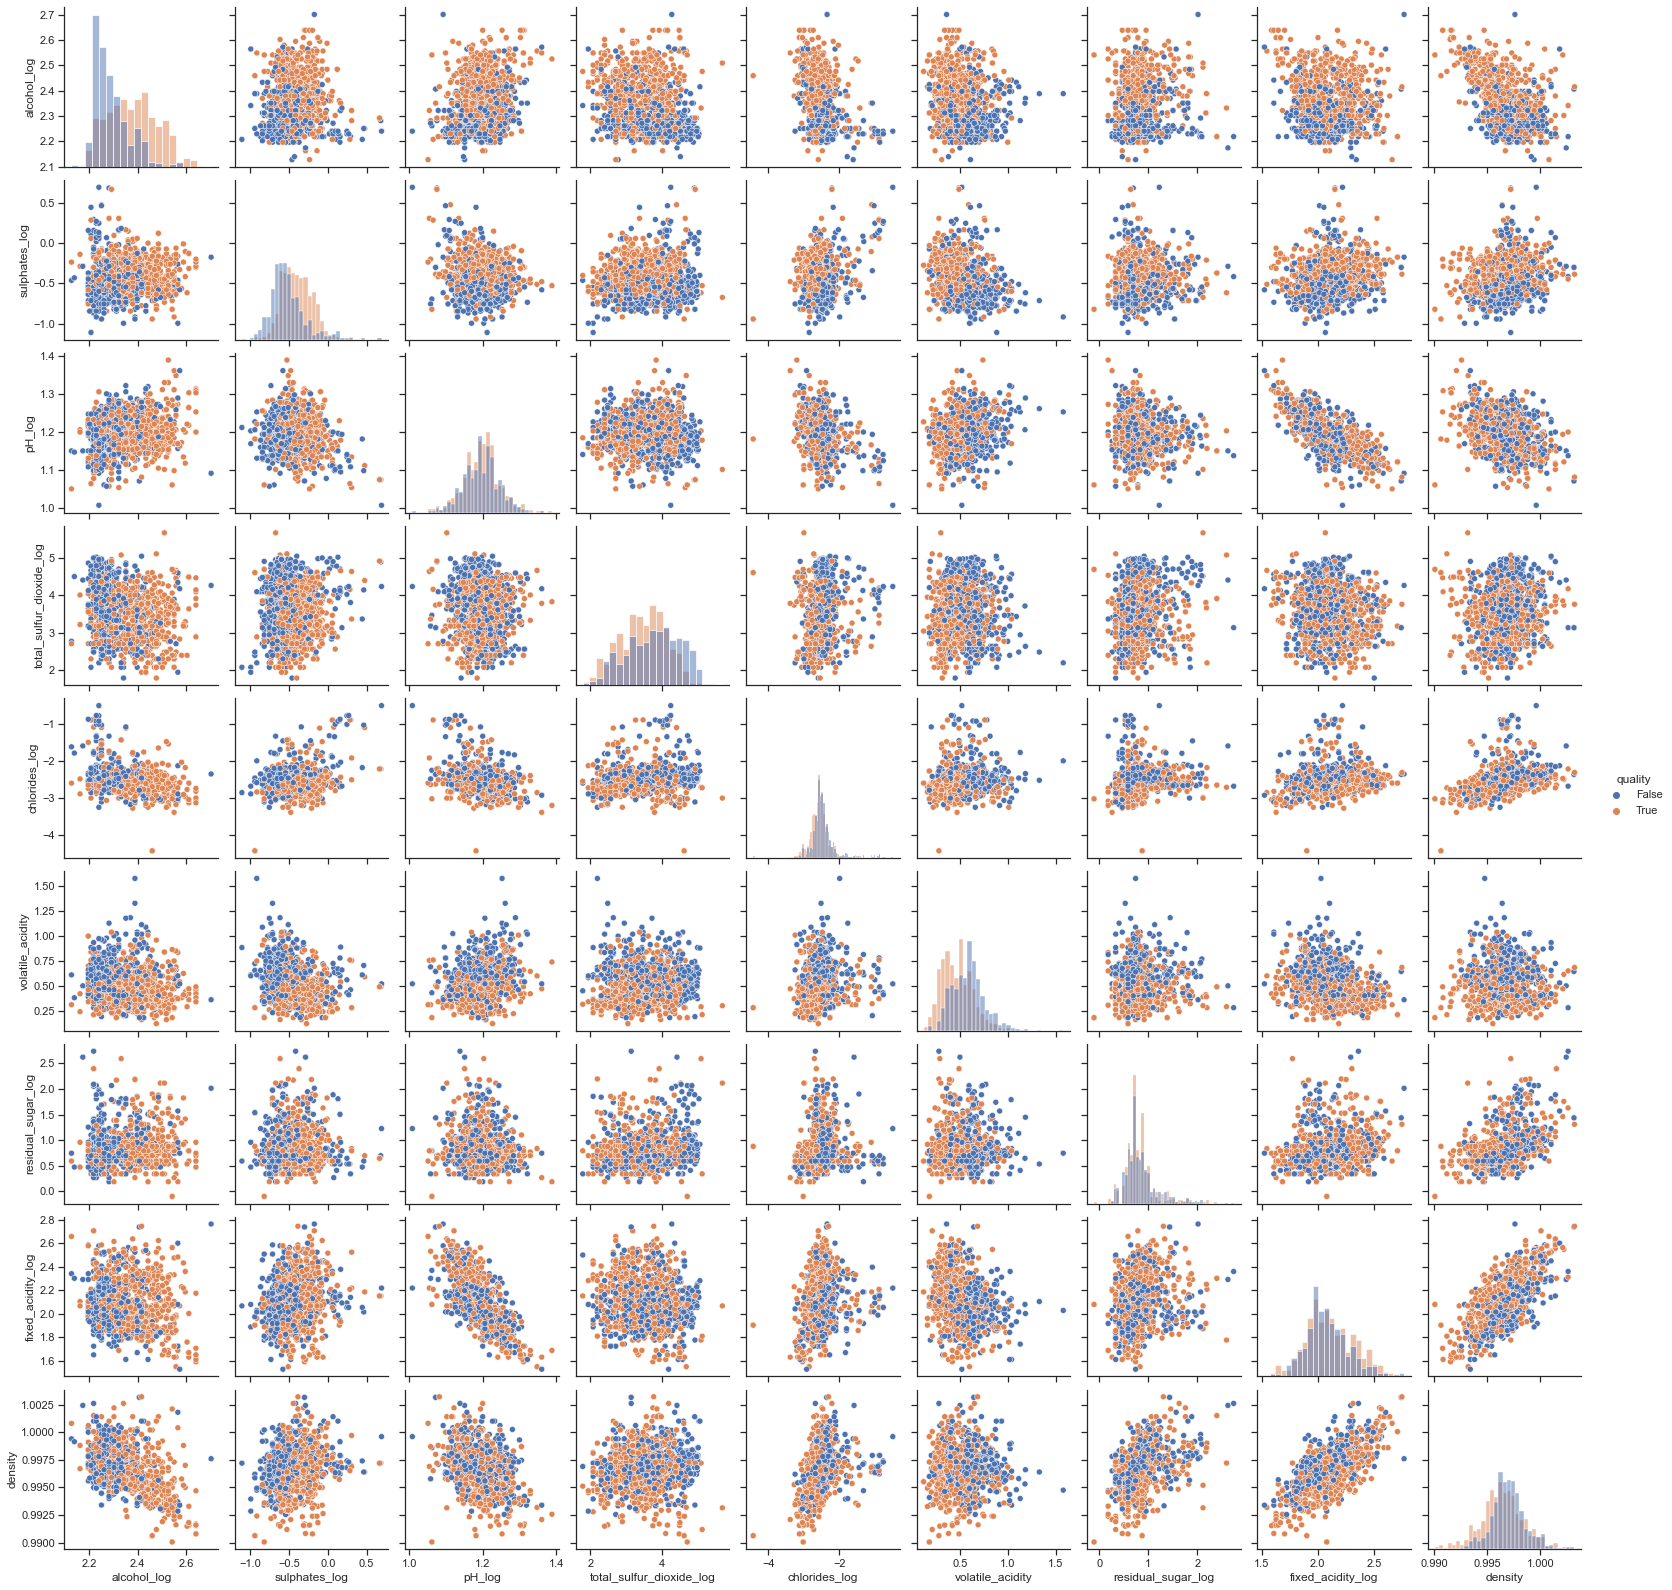

In [7]:
plt.show(sns.pairplot(df1_train, hue = 'quality', diag_kind='hist'))

Наблюдаем несколько выбросов, удалим их:

In [8]:
df1_train = df1_train.drop(df1_train[df1_train.chlorides_log < -4].index)
df1_train = df1_train.drop(df1_train[df1_train.total_sulfur_dioxide_log > 5.1].index)
df1_train = df1_train.drop(df1_train[df1_train.alcohol_log > 2.7].index)

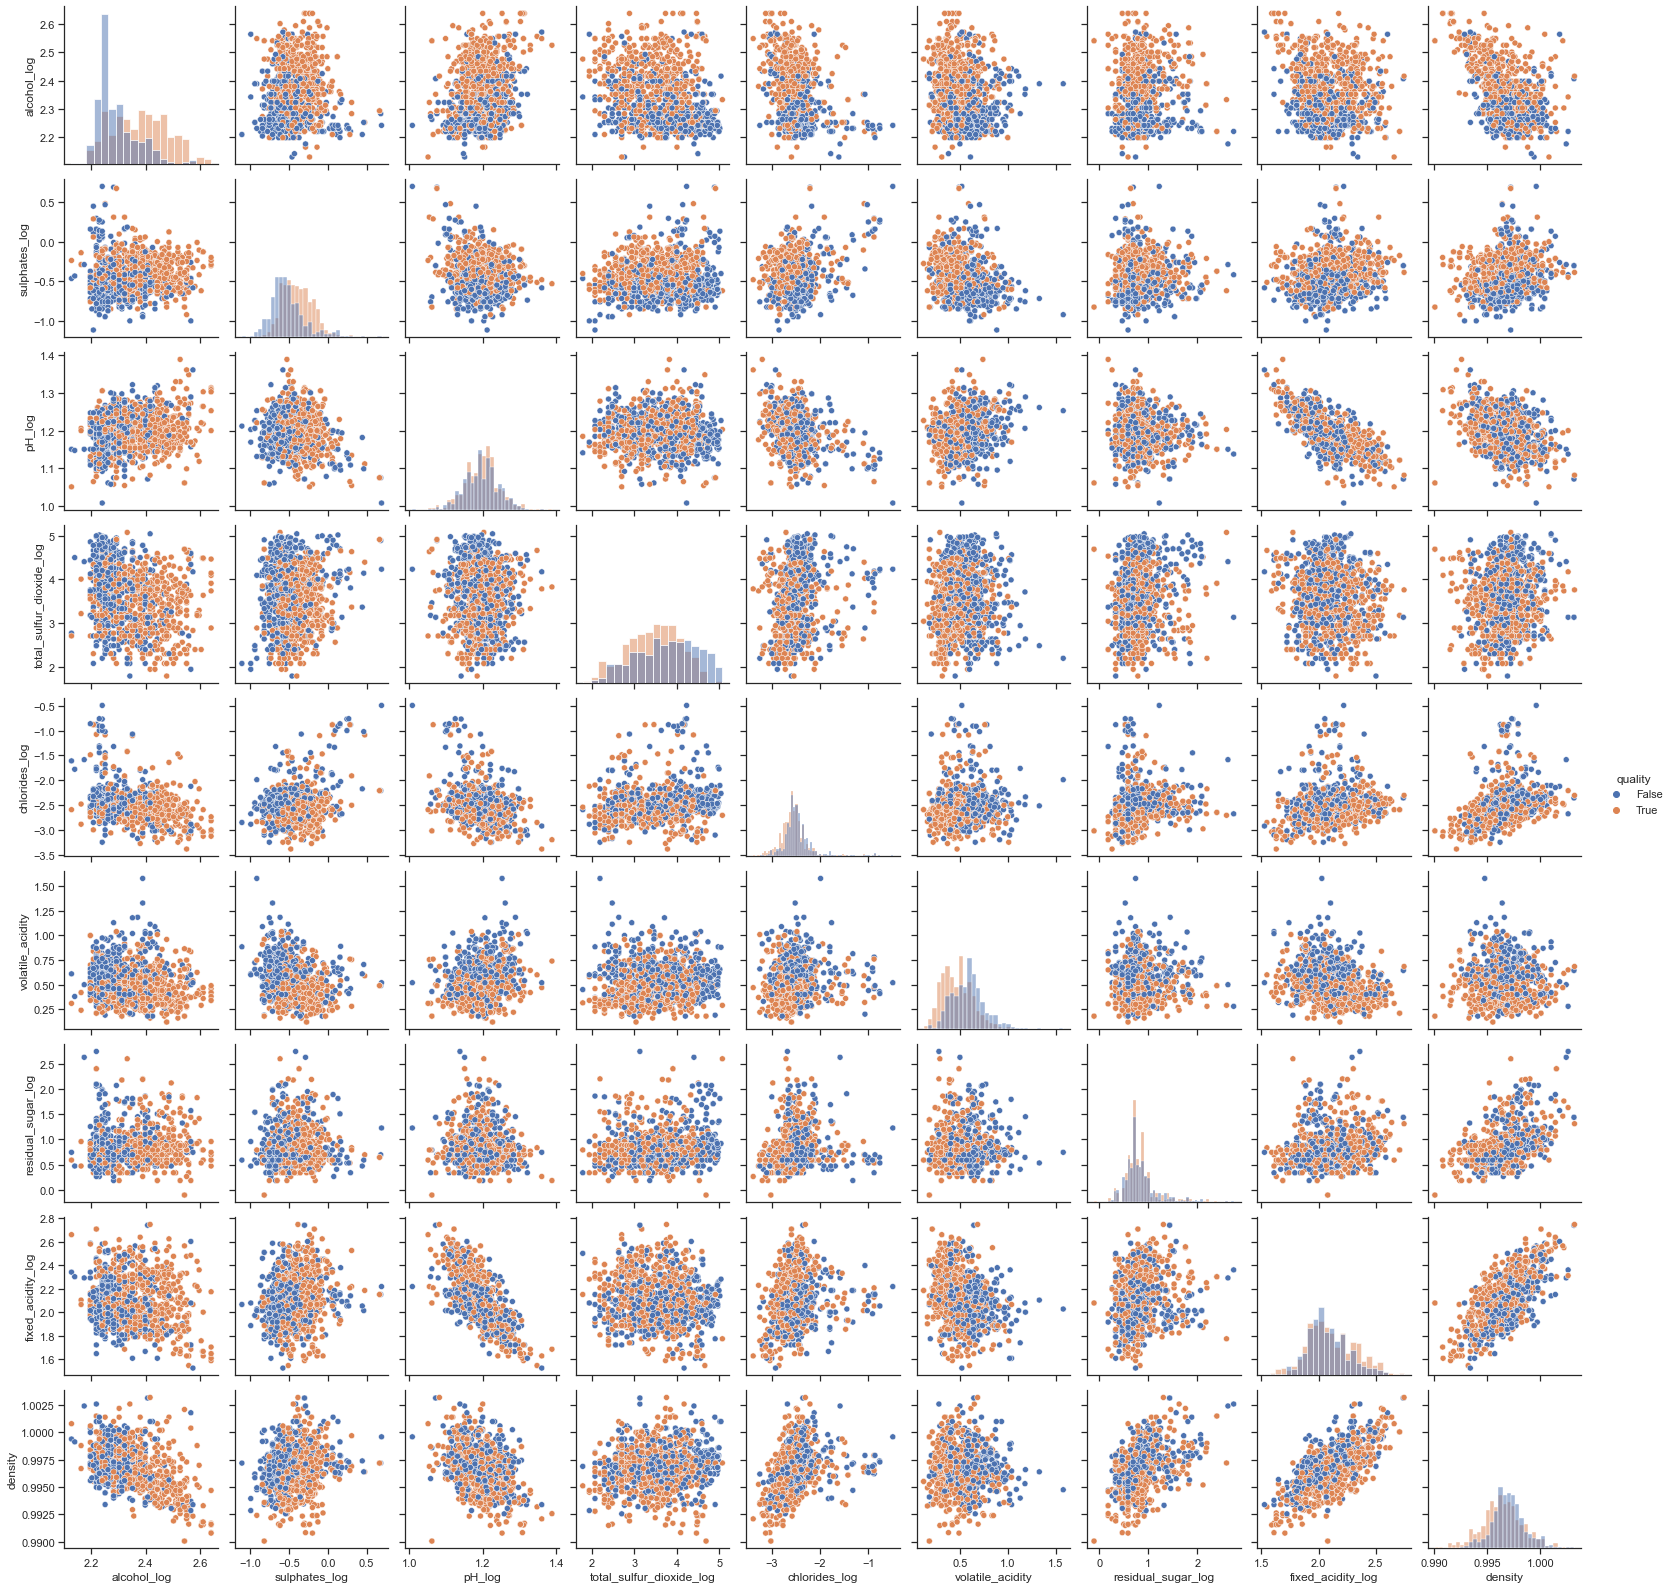

In [9]:
plt.show(sns.pairplot(df1_train, hue = 'quality', diag_kind='hist'))

In [10]:
df1_test.insert(1, 'fixed_acidity_log', np.log(df1_test['fixed acidity']))
df1_test.insert(1, 'residual_sugar_log', np.log(df1_test['residual sugar']))
df1_test.insert(1, 'volatile_acidity', df1_test['volatile acidity'])
df1_test.insert(1, 'chlorides_log', np.log(df1_test['chlorides']))
df1_test.insert(1, 'total_sulfur_dioxide_log', np.log(df1_test['total sulfur dioxide']))
df1_test.insert(1, 'pH_log', np.log(df1_test['pH']))
df1_test.insert(1, 'sulphates_log', np.log(df1_test['sulphates']))
df1_test.insert(1, 'alcohol_log', np.log(df1_test['alcohol']))
df1_test = df1_test.drop(['fixed acidity', 'volatile acidity','residual sugar', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol'], axis = 1)

Предположим, что ковариационные матрицы двух групп равны и проведем линейный дискриминантный анализ.

In [11]:
lda = LinearDiscriminantAnalysis()
lda.fit(df1_train.iloc[:, :-1], df1_train['quality'])
print(lda.score(df1_train.iloc[:, :-1], df1_train['quality']))
print(lda.score(df1_test.iloc[:, :-1], df1_test['quality']))

0.7511773940345369
0.721875


Точность на тестовом наборе около 72%.
Проверим значимость дискриминации.

In [12]:
from statsmodels.multivariate.manova import MANOVA
maov=MANOVA.from_formula('fixed_acidity_log + volatile_acidity + residual_sugar_log + chlorides_log + total_sulfur_dioxide_log + density + pH_log + sulphates_log + alcohol_log ~ quality', data=df1_train)
print(maov.mv_test())

                        Multivariate linear model
                                                                          
--------------------------------------------------------------------------
       Intercept           Value    Num DF   Den DF     F Value     Pr > F
--------------------------------------------------------------------------
          Wilks' lambda      0.0000 9.0000 1264.0000 128223544.4721 0.0000
         Pillai's trace      1.0000 9.0000 1264.0000 128223544.4721 0.0000
 Hotelling-Lawley trace 912984.0983 9.0000 1264.0000 128223544.4721 0.0000
    Roy's greatest root 912984.0983 9.0000 1264.0000 128223544.4721 0.0000
--------------------------------------------------------------------------
                                                                          
----------------------------------------------------------------------------
            quality           Value    Num DF     Den DF    F Value   Pr > F
----------------------------------------------

p-value во всех случаях близок к 0, гипотеза о значимости не отвергается.
Предположим, что ковариационные матрицы двух групп различны и проведем квадратичный дискриминантный анализ.

In [13]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(df1_train.iloc[:, :-1], df1_train['quality'])
print(qda.score(df1_train.iloc[:, :-1], df1_train['quality']))
print(qda.score(df1_test.iloc[:, :-1], df1_test['quality']))

0.7558869701726845
0.740625


Качество классификации на тестовом наборе немного увеличилось в сравнении с lda. 
Однако стоит помнить, что для этого нам понадобилось оценить намного больше параметров.
Перейдем к модели наивного байесовского классификатора:

In [14]:
gnb = GaussianNB()
gnb.fit(df1_train.iloc[:, :-1], df1_train['quality'])
print(gnb.score(df1_train.iloc[:, :-1], df1_train['quality']))
print(gnb.score(df1_test.iloc[:, :-1], df1_test['quality']))

0.7543171114599686
0.721875


Эта модель показала наилучший результат.